<a href="https://colab.research.google.com/github/ahlraf/ML-projects/blob/main/multiclass_text_classification_stackoverflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
print(tf.__version__)

2.4.1


**Sentiment analysis**<br>
Trains a sentiment analysis model to predict the tag of a programming question on Stack Overflow. 

Download and explore the IMDb dataset:

In [7]:
url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
data = tf.keras.utils.get_file("stack_overflow_16k", url, untar=True, cache_dir='.', cache_subdir='')

In [9]:
data_dir = os.path.dirname(data)
os.listdir(data_dir)

['.config',
 'stack_overflow_16k.tar.gz',
 'test',
 'train',
 'README.md',
 'sample_data']

In [10]:
train_dir = os.path.join(data_dir,'train')
os.listdir(train_dir)

['javascript', 'java', 'csharp', 'python']

In [11]:
sample_file = os.path.join(train_dir, 'javascript/5.txt')
with open(sample_file) as f:
  print(f.read())

"show specific output through if else statement i'm working out how to show entries in a dropdown list in dat.gui interface based on user input, but the issue i'm having is not related to the dat.gui programming, but rather my lack of blank skill...i've got two lists, one showing starsystem and 0 and 1 as designations..the other is planets that show the specific planets inside starsystem. .how do i program this statement so these two arrays only show when 0 or 1 is selected?..var jumpswitcher = 0;..    this.starsystems = 'dat.gui';.//starsystem list.    gui.add(this, 'starsystems', ['0', '1']).onchange(function(value) {.        if (value === '1') {.            jumpswitcher = 1;.        }.    });..    this.planets = 'dat.gui';.//if the var jumpswitcher is 0, display these variables in the planets array..    if (jumpswitcher === 0) {.        planets = ['mercury', 'venus', 'earth', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune'];.    } ..//if the jumpswitcher is 1, meaning if the user h

**Load the dataset**: using text_dataset_from_directory utility. To prepare dataset for binary classification, need 2 folders on disk: class_a and class_b --> +ve and -ve reviews.

Use text_dataset_from_directory utility to create labeled tf.data.Dataset .<br>Create 80:20 split of training data using validation_split:

In [12]:
batch_size = 32
seed = 42
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


==> There are 8000 examples in the training folder, we're using 80% (6400) for training.

In [13]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print('Question', text_batch.numpy()[i])
    print('Label', label_batch.numpy()[i])

Question b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default const

In [14]:
print('Label 0 corresponds to', raw_train_ds.class_names[0])
print('Label 1 corresponds to', raw_train_ds.class_names[1])
print('Label 2 corresponds to', raw_train_ds.class_names[2])
print('Label 3 corresponds to', raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


When using validation_split and subset arguments, we specify a random seed, pass shuffle=False so that validation and training splits have no overlap.

Validation set:

In [15]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


Test set:

In [16]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'test',
    batch_size=batch_size
)

Found 8000 files belonging to 4 classes.


### Prepare dataset for training
Standardize, tokenize, vectorize the data: using preprocessing.TextVectorization layer.<br><br>
Standardization = preprocessing the text (remove punctuation/ HTML elements - simplify dataset).<br>
Tokenization = splitting strings into tokens<br>
Vectorization = converting tokens into numbers so they can be fed into a neural network.<br><br>
HTML tags aren't removed by default standardizer in TextVectorization layer - write custom standardization function to remove the HTML.

To prevent train/test skew, preprocess data identically at train & test time - include TextVectorization layer inside model.

In [24]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

TextVectorization layer: use to standardize, tokenize, vectorize. Set output_mode to int to create unique integer indices for each token.
<br>
Using default split function + custom standardization function + define constants (explicit max sequence_length - layer pads/ truncates sequence accordingly).

In [26]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

Call adapt to fit the state of the preprocessing layer to the dataset - causes model to build an index of strings to integers.<br>

Use only training data when calling adapt (using test set leaks information).

In [27]:
# make text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y:x)
vectorize_layer.adapt(train_text)

In [28]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [29]:
# retrieve batch of 32 reviews and labels from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_ques, first_label = text_batch[0], label_batch[0] 
print("Question", first_ques)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized question", vectorize_text(first_ques, first_label))

Question tf.Tensor(b'"function expected error in blank for dynamically created check box when it is clicked i want to grab the attribute value.it is working in ie 8,9,10 but not working in ie 11,chrome shows function expected error..&lt;input type=checkbox checked=\'checked\' id=\'symptomfailurecodeid\' tabindex=\'54\' style=\'cursor:pointer;\' onclick=chkclickevt(this);  failurecodeid=""1"" &gt;...function chkclickevt(obj) { .    alert(obj.attributes(""failurecodeid""));.}"\n', shape=(), dtype=string)
Label javascript
Vectorized question (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  38,  450,   65,    7,   16,   12,  892,  265,  186,  451,   44,
          11,    6,  685,    3,   46,    4, 2062,    2,  485,    1,    6,
         158,    7,  479,    1,   26,   20,  158,    7,  479,    1,  502,
          38,  450,    1, 1767, 1763,    1,    1,    1,    1,    1,    1,
           1,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0

Each token has been replaced by an integer. Can look up the token each string corresponds to by calling .get_vocabulary() on the layer.

In [30]:
print("1287 -->", vectorize_layer.get_vocabulary()[1287])
print("313 -->", vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))

1287 --> scissors
313 --> source
Vocabulary size: 10000


Apply TextVectorization layer to train, validation, test dataset:

In [31]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configuring dataset for performance
.cache() --> keeps data in memory after it's loaded off disk; this ensures the dataset doesn't become a bottleneck while training. If dataset too large to fit into memory, this creates a permanent on-disk cache - more efficient that many small files.<br>
.prefetch() --> overlaps data preprocessing and model execution while training.

In [32]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create model

In [34]:
embedding_dim = 16

In [35]:
model = tf.keras.Sequential([
  layers.Embedding(max_features+1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)  # 4 classes now
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_________________________________________________________________


Layers stacked sequentially to build classifier:
1. Embedding layer: takes integer encoded reviews and looks up embedding vector for each word-index. Vectors learned at model trains, add dimension to output array. Resulting dimensions = (batch, sequence, embedding).
2. GlobalAveragePooling1D layer: returns fixed length output vector for each example by averaging over sequence dimension - allows model to handle input of variable length.
3. Fixed-length output vector piped through fully-connected (Dense) layer with 16 hidden units.
4. Last layer densely connected with single output node.

### Loss function and optimizer
Binary classification problem, model outputs probability (single unit layer with sigmoid activation) - losses.BinaryCrossentropy loss function + Adam optimizer.

In [36]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.SparseCategoricalCrossentropy(name="sparse_categorical_crossentropy",dtype=None,from_logits=True))
#from_logits=True ==> values of loss obtained by the model are not normalized

### Train model

In [37]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
200/200 [==============================] - 5s 20ms/step - loss: 1.3820 - sparse_categorical_crossentropy: 1.3820 - val_loss: 1.3685 - val_sparse_categorical_crossentropy: 1.3685
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 1.3603 - sparse_categorical_crossentropy: 1.3603 - val_loss: 1.3347 - val_sparse_categorical_crossentropy: 1.3347
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 1.3205 - sparse_categorical_crossentropy: 1.3205 - val_loss: 1.2817 - val_sparse_categorical_crossentropy: 1.2817
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 1.2604 - sparse_categorical_crossentropy: 1.2604 - val_loss: 1.2139 - val_sparse_categorical_crossentropy: 1.2139
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 1.1872 - sparse_categorical_crossentropy: 1.1872 - val_loss: 1.1395 - val_sparse_categorical_crossentropy: 1.1395
Epoch 6/10
200/200 [==============================] - 1s 7m

### Evaluate model


In [38]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 3s 13ms/step - loss: 0.8658 - sparse_categorical_crossentropy: 0.8658
Loss:  0.8657680153846741
Accuracy:  0.8657680153846741


### Plot of accuracy and loss over time
model.fit(): return History object that contains dictionary with everything that during training

In [39]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'sparse_categorical_crossentropy', 'val_loss', 'val_sparse_categorical_crossentropy'])

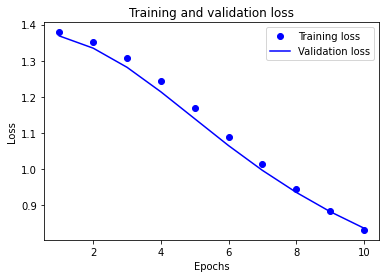

In [41]:
sparse = history_dict['sparse_categorical_crossentropy']
val_sparse = history_dict['val_sparse_categorical_crossentropy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(sparse)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

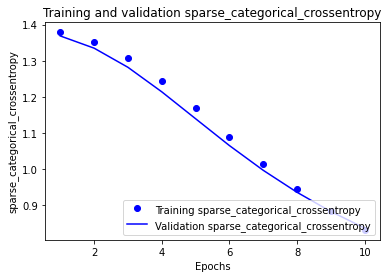

In [42]:
plt.plot(epochs, sparse, 'bo', label='Training sparse_categorical_crossentropy')
plt.plot(epochs, val_sparse, 'b', label='Validation sparse_categorical_crossentropy')
plt.title('Training and validation sparse_categorical_crossentropy')
plt.xlabel('Epochs')
plt.ylabel('sparse_categorical_crossentropy')
plt.legend(loc='lower right')

plt.show()

### Export model
To make model capable of processing raw strings: include TextVectorization layer inside the model. Create a new model using weights trained:

In [44]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=tf.metrics.SparseCategoricalCrossentropy(name="sparse_categorical_crossentropy",dtype=None,from_logits=True)
)

# test with raw_test_ds, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 4s 14ms/step - loss: 0.8610 - sparse_categorical_crossentropy: 0.8610
0.865767776966095


### Inference on new data
Call model.predict()

In [45]:
examples = [
  "How can sort a dictionary by value in Python",
]

export_model.predict(examples)

array([[0.51735884, 0.4578587 , 0.5420847 , 0.4855471 ]], dtype=float32)

Including text preprocessing logic - enables to export model for production + reduces potential for train/test skew.

Outside mode --> allows asynchronous CPU processing + buffering when training on GPU
Include TextVectorization when ready to deploy.